In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc
import os
import optuna
import sqlite3
import ray
import matplotlib.pyplot as plt
from optuna.integration import LightGBMPruningCallback
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')# Abrir el archivo parquet y cargarlo en un DataFrame data/l_vm_completa_train_pendientes.parquet
df_pendientes = pd.read_parquet('./data/l_vm_completa_train_pendientes.parquet', engine='fastparquet')
# Reunir los DataFrames df_full y df_pendientes por PRODUCT_ID, CUSTOMER_ID y PERIODO, agregar las 
# columnas de df_pendientes a df_full
df_full = df_full.merge(df_pendientes, on=['PRODUCT_ID', 'CUSTOMER_ID', 'PERIODO'], how='left', suffixes=('', '_features'))

In [3]:
# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
df_full['MES_PROBLEMATICO'] = df_full['PERIODO'].apply(lambda x: 1 if x in [201906, 201908] else 0)
# Optimizar tipos de datos numéricos
for col in df_full.select_dtypes(include=['int64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='integer')
for col in df_full.select_dtypes(include=['float64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='float')
# Variables categóricas
# categorical_features = ['ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','CUSTOMER_ID','PRODUCT_ID','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','PLAN_PRECIOS_CUIDADOS','MES_PROBLEMATICO']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')
# Hacer que A_PREDECIR sea boolean si es 'S' vale True, si es 'N' False
df_full['A_PREDECIR'] = df_full['A_PREDECIR'].map({'S': True, 'N': False})


In [4]:
# Hacer que CLASE_DELTA sea cero si es  nulo o infinito
df_full['CLASE_DELTA'] = df_full['CLASE_DELTA'].replace([np.inf, -np.inf], np.nan)
df_full['CLASE_DELTA'] = df_full['CLASE_DELTA'].fillna(0)
#df_full = df_full[df_full['CLASE_DELTA'].notnull() & np.isfinite(df_full['CLASE_DELTA'])]

In [5]:
# Variables predictoras y objetivo
# filtrar que en X el periodo sea menor o igual a 201910
# En x eliminar la columna 'CLASE' y 'CLASE_DELTA' si existen
cols_to_drop = [col for col in ['CLASE', 'CLASE_DELTA'] if col in df_full.columns]
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=cols_to_drop)
# Filtrar en y que el periodo sea menor o igual a 201910 y que la columna exista
y = df_full[df_full['PERIODO'] <= 201910]['CLASE_DELTA']
# Eliminar df_full para liberar memoria
del df_full
gc.collect()

30

In [6]:
# Definir los periodos de validación 201910
#periodos_valid = [201910]
periodos_valid = [201910]

# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]
X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]
del X, y
gc.collect()

0

In [7]:
from autogluon.tabular import TabularPredictor

# Dataset de entrenamiento
df_train = X_train.copy()
df_train['CLASE_DELTA'] = y_train

# Dataset de validación
df_val = X_val_list[0].copy()
df_val['CLASE_DELTA'] = y_val_list[0]

# Entrenamiento con AutoGluon optimizando MAE
predictor = TabularPredictor(
    label='CLASE_DELTA',
    problem_type='regression',
    eval_metric='mean_absolute_error'  # <- aquí especificás que te interesa el MAE
).fit(
    train_data=df_train,
    tuning_data=df_val,
    time_limit=3600,
    presets='best_quality',
    use_bag_holdout=True
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250627_003235"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.9.23
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #26~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Apr 17 19:20:47 UTC 2
CPU Count:          28
Memory Avail:       101.32 GB / 125.58 GB (80.7%)
Disk Space Avail:   396.91 GB / 543.17 GB (73.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/home/pablo/Documentos/labo3-2025v/AutogluonModels/ag-20250627_003235"
Train Data Rows:    15346065
Train Data Columns: 95
Tuning Data Rows:    561680
Tuning Data Columns: 95
Lab

In [8]:
# Cargo los datos sobre los que quiero hacer predicciones
gc.collect()
df_pred_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')
df_pred_full = df_pred_full[df_pred_full['PERIODO'] == 201910].drop(columns=['CLASE', 'CLASE_DELTA'])
df_pendientes = pd.read_parquet('./data/l_vm_completa_train_pendientes.parquet', engine='fastparquet')
df_pendientes = df_pendientes[df_pendientes['PERIODO'] == 201910]
df_pred_full = df_pred_full.merge(df_pendientes, on=['PRODUCT_ID', 'CUSTOMER_ID', 'PERIODO'], how='left', suffixes=('', '_features'))


In [9]:
# Filtrar solo los que tengan la columna A_PREDECIR con valor 1
df_pred_full = df_pred_full[df_pred_full['A_PREDECIR'] == 'S']
# Hacer que A_PREDECIR sea boolean si es 'S' vale True, si es 'N' False
df_pred_full['A_PREDECIR'] = df_pred_full['A_PREDECIR'].map({'S': True, 'N': False})

# Agregar a df_pred_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
df_pred_full['MES_PROBLEMATICO'] = df_pred_full['PERIODO'].apply(lambda x: 1 if x in [201906, 201908] else 0)
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

In [10]:
# Eliminar del dataframe df_pred_full la columna 'PREDICCIONES'
if 'PREDICCIONES' in df_pred_full.columns:
    df_pred_full.drop(columns=['PREDICCIONES'], inplace=True)

📊 Evaluación en df_val:
{'mean_absolute_error': -0.05015942454338074, 'root_mean_squared_error': np.float32(-0.790873), 'mean_squared_error': -0.6254801154136658, 'r2': 0.46890830993652344, 'pearsonr': 0.6864783763885498, 'median_absolute_error': np.float32(-0.0014407488)}


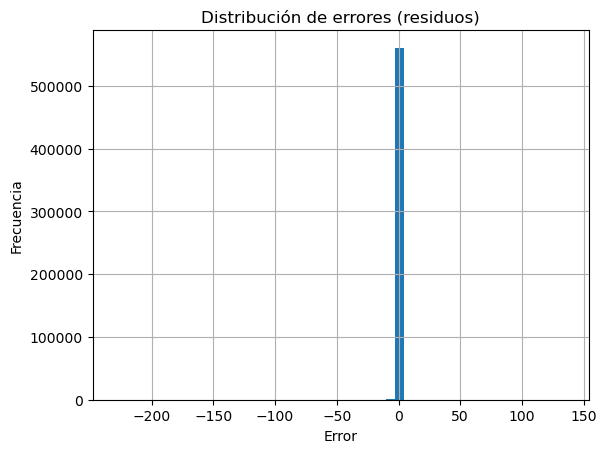

RMSE: 0.7909
MAE : 0.0502
🏆 Leaderboard:


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.050159,-0.050159,mean_absolute_error,24.406654,24.881669,2371.409972,0.006503,0.002723,0.204692,3,True,6
1,WeightedEnsemble_L2,-0.050237,-0.050237,mean_absolute_error,23.790440,24.242199,2212.012627,0.004268,0.003185,0.121101,2,True,3
2,LightGBMXT_BAG_L1,-0.051050,-0.051050,mean_absolute_error,21.797885,22.186241,1942.754478,21.797885,22.186241,1942.754478,1,True,1
3,LightGBM_BAG_L1,-0.051172,-0.051172,mean_absolute_error,1.988287,2.052773,269.137049,1.988287,2.052773,269.137049,1,True,2
4,LightGBMXT_BAG_L2,-0.051219,-0.051219,mean_absolute_error,26.083247,26.528217,2709.356582,2.297075,2.289202,497.465056,2,True,4
5,LightGBM_BAG_L2,-0.060390,-0.060390,mean_absolute_error,24.400151,24.878946,2371.205280,0.613979,0.639932,159.313754,2,True,5


In [11]:
# --- 1. Evaluar en validación ---
print("📊 Evaluación en df_val:")
eval_result = predictor.evaluate(df_val)
print(eval_result)

# --- 2. Visualizar distribución de errores ---
y_true = df_val["CLASE_DELTA"]
y_pred = predictor.predict(df_val)

residuals = y_true - y_pred
plt.hist(residuals, bins=50)
plt.title("Distribución de errores (residuos)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# --- 3. Métricas personalizadas ---
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# --- 4. Leaderboard de modelos ---
print("🏆 Leaderboard:")
predictor.leaderboard(df_val, silent=True)


In [12]:

# --- 5. Predicción sobre datos pendientes ---
if not df_pred_full.empty:
    df_pred_full = df_pred_full.drop(columns=["CLASE_DELTA"], errors="ignore")
    df_pred_full["CLASE_DELTA_PRED"] = predictor.predict(df_pred_full)
    print("✅ Predicciones generadas.")
else:
    print("⚠️ df_pred_full está vacío. No se generaron predicciones.")

# --- 6. Exportar resultados ---
output_cols = ["PRODUCT_ID", "CUSTOMER_ID", "PERIODO", "CLASE_DELTA_PRED"]
output_path = "predicciones_autogluon.parquet"

if "CLASE_DELTA_PRED" in df_pred_full.columns:
    df_pred_full[output_cols].to_parquet(output_path, index=False)
    print(f"📁 Archivo exportado: {output_path}")
else:
    print("❌ No se encontró la columna 'CLASE_DELTA_PRED'.")


✅ Predicciones generadas.
📁 Archivo exportado: predicciones_autogluon.parquet
